<a href="https://colab.research.google.com/github/Ugo5738/Convolutional-Neural-Networks-Projects/blob/main/Captcha_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset from Kaggle

In [1]:
!pip install --quiet kaggle

# upload the kaggle.json file from your local system
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ugochukwunwachukwu","key":"affd591e4e369e7e953e082ec357450d"}'}

In [2]:
# make the /.kaggle directory
!mkdir -p ~/.kaggle

# copy the kaggle.json file into the /.kaggle directory
!cp kaggle.json ~/.kaggle
# check the files in the /.kaggle directory

!ls /root/.kaggle/
# check the file permission 

!ls -l ~/.kaggle/kaggle.json
# change file permission
# chmod 600 - owner can write and read
# chmod 700 - owner can write, read and execute

!chmod 600 ~/.kaggle/kaggle.json

kaggle.json
-rw-r--r-- 1 root root 74 Mar 14 16:41 /root/.kaggle/kaggle.json


In [3]:
!kaggle datasets list -s 'captcha images'

ref                                      title                              size  lastUpdated          downloadCount  
---------------------------------------  --------------------------------  -----  -------------------  -------------  
fournierp/captcha-version-2-images       CAPTCHA Images                     17MB  2019-02-27 03:04:17           6202  
aadhavvignesh/captcha-images             Captcha Images                     32MB  2020-07-30 16:33:11            142  
codingnirvana/captcha-images             Captcha Images                      4MB  2017-10-06 10:32:37           1456  
alizahidraja/captcha-data                Captcha data                        9MB  2020-09-26 22:04:29             68  
famadio/captcha-2-text                   Captcha 2 text                      9MB  2019-03-02 13:01:38            385  
parsasam/captcha-dataset                 CAPTCHA Dataset                   356MB  2021-03-04 18:29:56             15  
libowei/12306-captcha-image              12306 c

In [4]:
!kaggle datasets download -d kislayai/captcha-image-set-95134-images

 99% 538M/544M [00:05<00:00, 129MB/s]
100% 544M/544M [00:05<00:00, 103MB/s]


# Unzip Dataset into working directories

In [5]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from PIL import Image

tf.__version__

'2.4.1'

In [6]:
base_dir = '/content/captcha-image-set-95134-images.zip'
zip_ref = zipfile.ZipFile(base_dir, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Extract images and labels into a dataframe

In [9]:
base_dir = '/tmp/captcha_images_v2/'

image_list = os.listdir(base_dir)
label_list = []
image_path_list = []

for image in image_list:
    image_path = os.path.join(base_dir, image)
    image_path_list.append(image_path)
    label = image.split('.')[0]
    label_list.append(label)

image_df = pd.DataFrame(
    {'labels': label_list,
     'image_path': image_path_list,
    })

image_df

,labels,image_path
0,111878,/tmp/captcha_images_v2/111878.png
1,328957,/tmp/captcha_images_v2/328957.png
2,678001,/tmp/captcha_images_v2/678001.png
3,927124,/tmp/captcha_images_v2/927124.png
4,875303,/tmp/captcha_images_v2/875303.png
...,...,...
95128,278173,/tmp/captcha_images_v2/278173.png
95129,996375,/tmp/captcha_images_v2/996375.png
95130,471363,/tmp/captcha_images_v2/471363.png
95131,174075,/tmp/captcha_images_v2/174075.png


# Create a train, validation and test set

In [12]:
import numpy as np
p_df = np.random.permutation(len(image_df)) #shuffle dataframe
split_point = int(len(image_df) * 0.7)
train_idx = p_df[:split_point]
test_idx = p_df[split_point:]

# split train_idx further into training and validation set
split_point = int(split_point * 0.7)
train_idx, validation_idx = train_idx[:split_point], train_idx[split_point:]

print(f'train count: {len(train_idx)}, validation count: {len(validation_idx)}, test count: {len(test_idx)}')

train count: 46615, validation count: 19978, test count: 28540


In [13]:
H, W, C = 150, 150, 3
N_LABELS = 10 # number of categories, figure can change when using ascii
D = 6 # number of digits

def get_data_generator(image_df, indices, for_training, batch_size):
    images, labels = [], []
    while True:
        for i in indices:
            r = image_df.iloc[i]
            image, label = r['image_path'], r['labels']
            im = Image.open(image)
            im = im.resize((150, 150))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(int(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
                # print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

In [14]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf

input_layer = tf.keras.Input(shape=(150, 150, 3))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

x = layers.Dense(D * N_LABELS, activation='softmax')(x)
x = layers.Reshape((D, N_LABELS))(x)


model = Model(inputs=input_layer, outputs=x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_generator = get_data_generator(image_df, train_idx, for_training=True, batch_size=batch_size)
valid_generator = get_data_generator(image_df, validation_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_generator,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=5,
                    verbose=1,
#                     callbacks=callbacks,
                    validation_data=valid_generator,
                    validation_steps=len(validation_idx)//valid_batch_size)

Epoch 1/5
728/728 [==============================] - 148s 161ms/step - loss: 0.6729 - accuracy: 0.7655 - val_loss: 0.0352 - val_accuracy: 0.9894
Epoch 2/5
728/728 [==============================] - 115s 159ms/step - loss: 0.0220 - accuracy: 0.9933 - val_loss: 0.0235 - val_accuracy: 0.9927
Epoch 3/5
728/728 [==============================] - 114s 157ms/step - loss: 0.0142 - accuracy: 0.9954 - val_loss: 0.0171 - val_accuracy: 0.9949
Epoch 4/5
728/728 [==============================] - 114s 156ms/step - loss: 0.0106 - accuracy: 0.9965 - val_loss: 0.0148 - val_accuracy: 0.9955
Epoch 5/5
728/728 [==============================] - 113s 156ms/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.0122 - val_accuracy: 0.9967


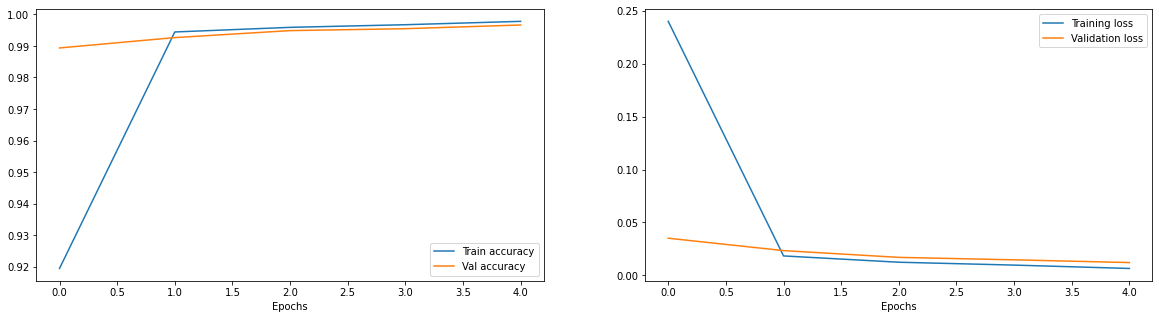

In [24]:
import matplotlib.pyplot as plt

def  plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [25]:
test_generator = get_data_generator(image_df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_generator, steps=len(test_idx)//128)))

222/222 [==============================] - 50s 225ms/step - loss: 0.0144 - accuracy: 0.9964


{'accuracy': 0.9964339137077332, 'loss': 0.014358757063746452}

In [26]:
test_generator = get_data_generator(image_df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_generator)

y_pred = model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)

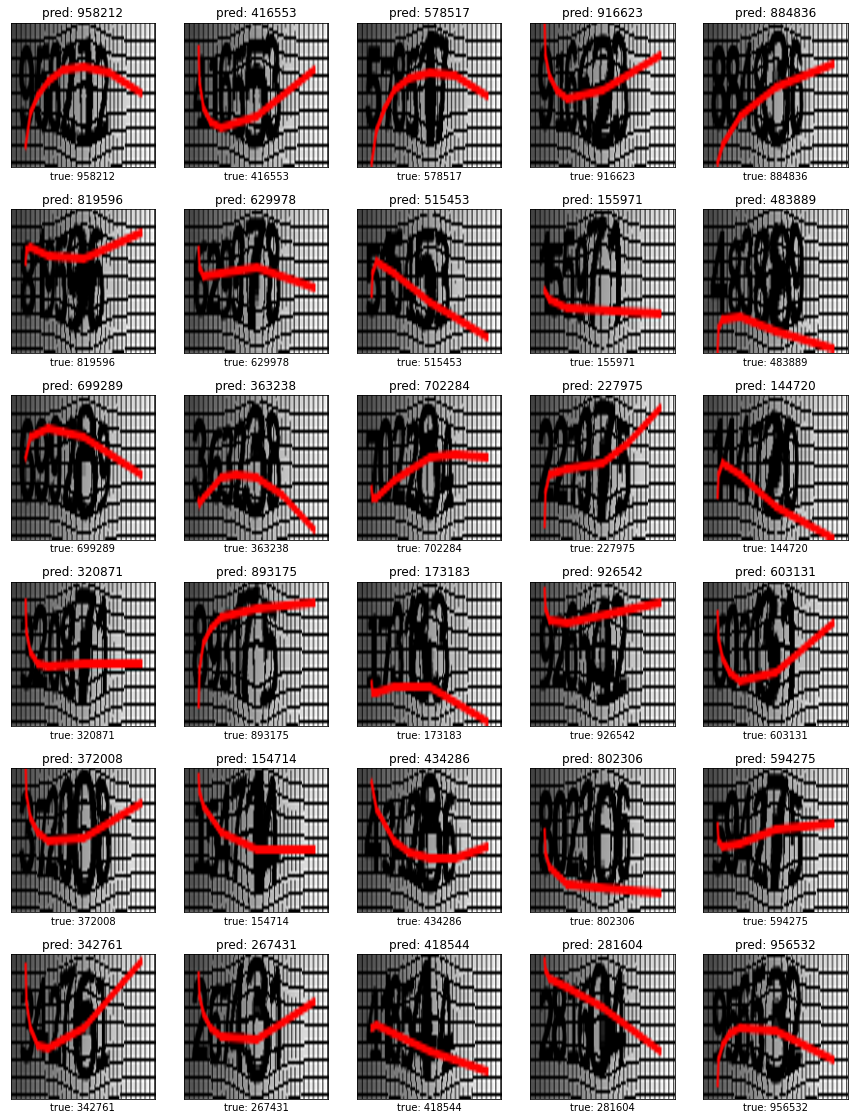

In [27]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('pred: {}'.format(
        ''.join(map(str, y_pred[img_idx].numpy()))))
    ax.set_xlabel('true: {}'.format(
        ''.join(map(str, y_true[img_idx].numpy()))))
    ax.set_xticks([])
    ax.set_yticks([])